In [1]:
import glob
import os
import numpy as np
import pandas as pd
import open3d as o3d
from matplotlib import pyplot as plt
from shapely.geometry import MultiLineString, Point, LineString
from shapely.ops import unary_union, polygonize
import scipy
from scipy.spatial import Delaunay, ConvexHull, distance_matrix
from collections import Counter
import itertools
import time
import cv2
import copy
import utils
import skimage
import enum

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
SSM_DIR = r"./data/cpdAlignedData/eigValVec/"
CPD_ALIGNED_DIR = r"./data/cpdAlignedData/"
NAME_IDX_MAP_CSV = r"./dataWithPhoto/nameIndexMapping.csv"
EDGE_MASK_PATH = r"./dataWithPhoto/normal_mask/"
NUM_PC = 20
SHIFT_VEC = np.array([0.,10.,0.])
PG_NPY = os.path.join("res-2D-3D", "Y_pg.npy")
MASK_NPY = os.path.join("res-2D-3D", "X_mask.npy")
PARAM_DIR = r"./data/params/"
UPPER_INDICES = [11,12,13,14,15,16,17,21,22,23,24,25,26,27] #不考虑智齿18,28
LOWER_INDICES = [31,32,33,34,35,36,37,41,42,43,44,45,46,47] #不考虑智齿38,48

In [3]:
TagID = 47 # 63 # 
name_idx_df = pd.read_csv(NAME_IDX_MAP_CSV)
photo_types = ["upperPhoto","lowerPhoto","leftPhoto","rightPhoto","frontalPhoto"]

In [4]:
def getEdgeMask(edge_mask_path, name_idx_df, TagID, photo_types, resized_width=800):
    photoFiles = name_idx_df.loc[name_idx_df["index"]==TagID, photo_types].values[0]
    print(photoFiles)
    edgeMaskFiles = [os.path.join(edge_mask_path, os.path.basename(pf)) for pf in photoFiles]
    edgeMasks = []
    for edgeMaskFile in edgeMaskFiles:
        edgeMask = skimage.io.imread(edgeMaskFile, as_gray=True)
        rescale = resized_width / edgeMask.shape[1]
        edgeMask = skimage.transform.rescale(edgeMask, rescale, anti_aliasing=True)
        thre = 0.5
        edgeMask[edgeMask<thre] = 0.
        edgeMask[edgeMask>=thre] = 1.
        # edgeMask = skimage.morphology.binary_erosion(edgeMask, footprint=skimage.morphology.disk(2))
        edgeMasks.append(edgeMask)
    return edgeMasks

In [5]:
edgeMasks = getEdgeMask(EDGE_MASK_PATH, name_idx_df, TagID, photo_types, resized_width=800)

['.\\dataWithPhoto\\normal\\曾思棋_219446_上牙列.jpg'
 '.\\dataWithPhoto\\normal\\曾思棋_219446_下牙列.jpg'
 '.\\dataWithPhoto\\normal\\曾思棋_219446_左侧咬合.jpg'
 '.\\dataWithPhoto\\normal\\曾思棋_219446_右侧咬合.jpg'
 '.\\dataWithPhoto\\normal\\曾思棋_219446_正位像.jpg']


num of contour points in upperPhoto: 6420 
num of contour points in lowerPhoto: 5266 
num of contour points in leftPhoto: 7596 
num of contour points in rightPhoto: 8767 
num of contour points in frontalPhoto: 10386 


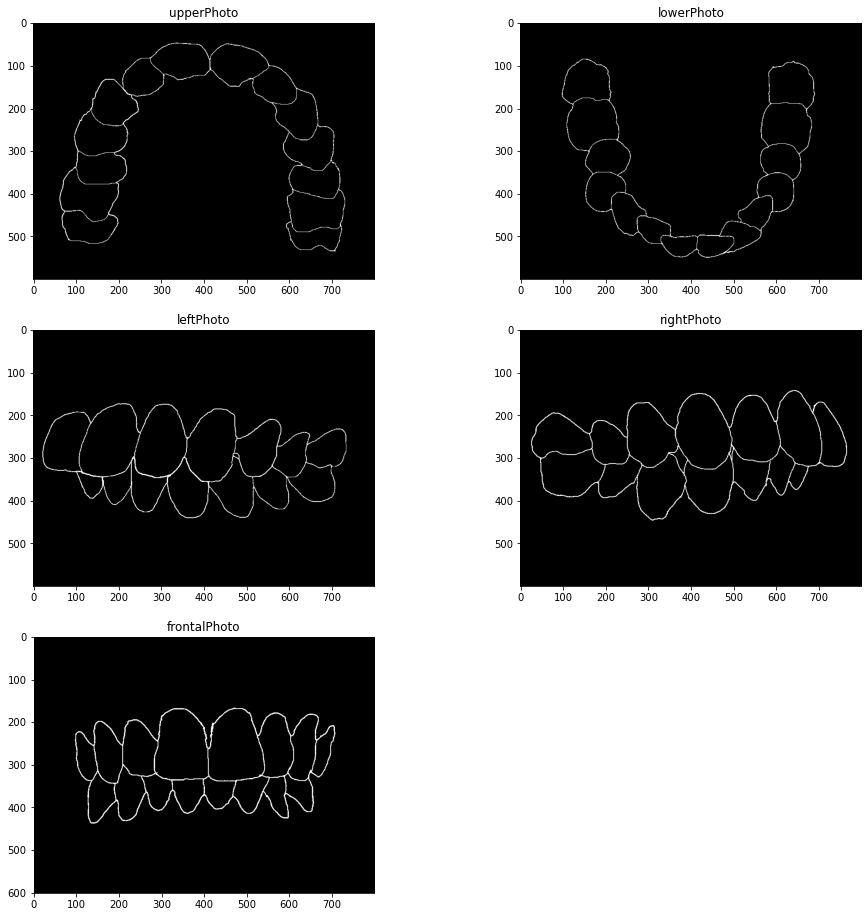

In [6]:
plt.figure(figsize=(16,16))
for i,ptype in enumerate(photo_types):
    plt.subplot(3,2,i+1)
    plt.imshow(edgeMasks[i], cmap='gray')
    plt.title(ptype)
    print("num of contour points in {}: {} ".format(ptype, np.sum(edgeMasks[i]>0)))

In [7]:
def GetPGByTagId(pg_npy, TagId):
    PGs = np.load(pg_npy)
    return PGs[TagId]

def GetMaskByTagId(mask_npy, TagId):
    Masks = np.load(mask_npy)
    return np.squeeze(Masks[TagId]) # shape=(28,)

def __getToothIndex(f):
    return int(os.path.basename(f).split(".")[0].split("_")[-1])

def loadMuEigValSigma(ssmDir, numPC=NUM_PC):
    """Mu.shape=(28,1500,3), sqrtEigVals.shape=(28,1,100), Sigma.shape=(28,4500,100)"""
    muNpys = glob.glob(os.path.join(ssmDir,"meanAlignedPG_*.npy"))
    muNpys = sorted(muNpys, key=lambda x:__getToothIndex(x))
    Mu = np.array([np.load(x) for x in muNpys])
    eigValNpys = glob.glob(os.path.join(ssmDir,"eigVal_*.npy"))
    eigValNpys = sorted(eigValNpys, key=lambda x:__getToothIndex(x))
    sqrtEigVals = np.sqrt(np.array([np.load(x) for x in eigValNpys]))
    eigVecNpys = glob.glob(os.path.join(ssmDir,"eigVec_*.npy"))
    eigVecNpys = sorted(eigVecNpys, key=lambda x:__getToothIndex(x))
    Sigma = np.array([np.load(x) for x in eigVecNpys])
    return Mu, sqrtEigVals[:,np.newaxis,:numPC], Sigma[...,:numPC]

def GetPgRefUL(PgRef, Mask, shiftVec):
    PG_U, PG_L = np.split(PgRef, 2, axis=0)
    PG_U = PG_U + shiftVec
    PG_L = PG_L - shiftVec
    Mask_U, Mask_L = np.split(Mask, 2, axis=0)
    return PG_U[Mask_U], PG_L[Mask_L]

In [8]:
Mu, SqrtEigVals, Sigma = loadMuEigValSigma(SSM_DIR, numPC=NUM_PC)
Mask = GetMaskByTagId(MASK_NPY, TagId=TagID)

In [9]:
# reference
PG_Ref = GetPGByTagId(PG_NPY, TagId=TagID)
X_Ref_U, X_Ref_L = GetPgRefUL(PG_Ref, Mask, SHIFT_VEC)

In [494]:
utils.showPointCloud(np.concatenate([X_Ref_U, X_Ref_L]).reshape(-1,3), "Reference PointCloud")

In [10]:
def loadInvRegistrationParams(loadDir):
    """生成DataFrame,含有逆配准参数s,R,transVec,transVecShift"""
    """initPG = np.multiply(s, np.matmul(PG+transVec, R)) + transVecShift"""
    toothIndices = UPPER_INDICES + LOWER_INDICES
    paramDF = pd.DataFrame(columns=["tag"])
    # 下牙列逆配准参数
    tags, rowScales, transVecShifts = utils.readToothRowScalesFromHDF5(os.path.join(loadDir, "scalesOfLowerToothRow.hdf5"), "L")
    indexTag = [int(tag[:-1]) for tag in tags]
    invScales = [1./s for s in rowScales]
    invTransVecShifts = -transVecShifts
    tempDF = pd.DataFrame({"tag":indexTag,"lower_s":list(invScales), "lower_ts":list(invTransVecShifts)})
    paramDF = paramDF.merge(tempDF, how="outer", on="tag")
    # 上牙列逆配准参数
    tags, rowScales, transVecShifts = utils.readToothRowScalesFromHDF5(os.path.join(loadDir, "scalesOfUpperToothRow.hdf5"), "U")
    indexTag = [int(tag[:-1]) for tag in tags]
    invScales = [1./s for s in rowScales]
    invTransVecShifts = -transVecShifts
    tempDF = pd.DataFrame({"tag":indexTag,"upper_s":list(invScales), "upper_ts":list(invTransVecShifts)})
    paramDF = paramDF.merge(tempDF, how="outer", on="tag")
    # 牙齿统计形状逆配准参数
    for i in toothIndices:
        h5File = os.path.join(loadDir, "sRtParams_{}.hdf5".format(i))
        tags, scales, rotMats, transVecs = utils.readRegistrationParamsFromHDF5(h5File, i)
        indexTag = [int(tag[:-1]) for tag in tags]
        invRotAngles = np.array([utils.rotationMatrixToEulerAngles(r.T) for r in rotMats])
        invScales = 1./scales
        invTransVecs = -transVecs
        tempDF = pd.DataFrame({"tag":indexTag,"{}s".format(i):list(invScales), "{}rx".format(i):list(invRotAngles[:,0]), \
                               "{}ry".format(i):list(invRotAngles[:,1]), "{}rz".format(i):list(invRotAngles[:,2]), \
                               "{}tx".format(i):list(invTransVecs[:,0]), "{}ty".format(i):list(invTransVecs[:,1]), \
                               "{}tz".format(i):list(invTransVecs[:,2])})
        paramDF = paramDF.merge(tempDF, how="outer", on="tag")
    sUpperColumns = ["{}s".format(id) for id in UPPER_INDICES]
    sLowerColumns = ["{}s".format(id) for id in LOWER_INDICES]
    paramDF = paramDF[~paramDF[sUpperColumns].isna().all(axis=1)]
    paramDF = paramDF[~paramDF[sLowerColumns].isna().all(axis=1)] # 删除缺少上牙列或下牙列的数据
    paramDF = paramDF.sort_values(by="tag", ignore_index=True)
    return paramDF

def updateAbsTransVecs(invParamDF, Mu):
    """将牙列transVecShift融入txyz中，忽略牙列scale的影响，并且将txyz定义在局部坐标系下"""
    toothIndices = UPPER_INDICES+LOWER_INDICES
    invParamCopy = invParamDF.copy()
    numSample = invParamDF.shape[0]
    numTooth = len(toothIndices)
    X_Mu_centroids = {tID:Mu[i].mean(axis=0) for i,tID in enumerate(toothIndices)}
    invScalesColumns = ["{}s".format(id) for id in toothIndices]
    invRotAngleXYZColumns = ["{}r{}".format(id, p) for id in toothIndices for p in ["x","y","z"]]
    invTransVecXYZColumns = ["{}t{}".format(id, p) for id in toothIndices for p in ["x","y","z"]]
    invTransVecShiftColumns = ["upper_ts", "lower_ts"]
    invScales = invParamDF[invScalesColumns].to_numpy()
    invRotAngles = invParamDF[invRotAngleXYZColumns].to_numpy().reshape(numSample, numTooth, 3)
    invTransVecs = invParamDF[invTransVecXYZColumns].to_numpy().reshape(numSample, numTooth, 3)
    invTransVecShifts = np.concatenate([np.stack(invParamDF["upper_ts"].to_list()), np.stack(invParamDF["lower_ts"].to_list())], axis=1)
    
    for i in range(numSample):
        for j,tID in enumerate(toothIndices):
            rxyz = invRotAngles[i,j]
            invRotMat = utils.getRotMat(rxyz) if not np.isnan(rxyz).any() else np.identity(3)
            invTx, invTy, invTz = - X_Mu_centroids[tID] + invScales[i,j] * (invTransVecs[i,j] + X_Mu_centroids[tID] - invTransVecShifts[i,j]) @ invRotMat
            invParamCopy.loc[i,"{}tx".format(tID)] = invTx
            invParamCopy.loc[i,"{}ty".format(tID)] = invTy
            invParamCopy.loc[i,"{}tz".format(tID)] = invTz
    invParamCopy = invParamCopy.drop(labels=["upper_s", "lower_s", "upper_ts", "lower_ts"], axis=1)
    return invParamCopy
            
            

def getMeanAndVarianceOfInvRegistrationParams(invParamDF):
    toothIndices = UPPER_INDICES+LOWER_INDICES
    numTooth = len(toothIndices)
    invScalesColumns = ["{}s".format(id) for id in toothIndices]
    invRotAngleXYZColumns = ["{}r{}".format(id, p) for id in toothIndices for p in ["x","y","z"]]
    invTransVecXYZColumns = ["{}t{}".format(id, p) for id in toothIndices for p in ["x","y","z"]]
    invScales = invParamDF[invScalesColumns].to_numpy()
    invScaleMeans = np.nanmean(invScales, axis=0)
    invScaleVars = np.nanvar(invScales, ddof=1, axis=0)
    invRotAngleXYZs = invParamDF[invRotAngleXYZColumns].to_numpy()
    invRotAngleXYZMeans = np.nanmean(invRotAngleXYZs, axis=0).reshape(numTooth,3)
    invRotAngleXYZVars = np.nanvar(invRotAngleXYZs, ddof=1, axis=0).reshape(numTooth,3)
    invTransVecXYZs = invParamDF[invTransVecXYZColumns].to_numpy()
    invTransVecXYZMeans = np.nanmean(invTransVecXYZs, axis=0).reshape(numTooth,3)
    invTransVecXYZVars = np.nanvar(invTransVecXYZs, ddof=1, axis=0).reshape(numTooth,3)
    return invScaleMeans, invScaleVars, invRotAngleXYZMeans, invRotAngleXYZVars, invTransVecXYZMeans, invTransVecXYZVars
    
    

In [11]:
invRegistrationParamDF = loadInvRegistrationParams(loadDir=PARAM_DIR)
invParamDF = updateAbsTransVecs(invRegistrationParamDF, Mu)

In [12]:
np.nanvar(invRegistrationParamDF["23ty"].to_numpy(),ddof=1)

6.55427454653292

In [13]:
# cols = ["{}s".format(id) for id in UPPER_INDICES+LOWER_INDICES]
# cols = ["{}r{}".format(id, p) for id in UPPER_INDICES for p in ["x","y","z"]]
# cols = ["{}r{}".format(id, p) for id in LOWER_INDICES for p in ["x","y","z"]]
# cols = ["{}t{}".format(id, p) for id in UPPER_INDICES for p in ["x","y","z"]]
# cols = ["{}t{}".format(id, p) for id in LOWER_INDICES for p in ["x","y","z"]]

toothIndices = UPPER_INDICES+LOWER_INDICES
suffixes = ["s","tx","ty","tz","rx","ry","rz"]
cols = ["11"+suffix for suffix in suffixes]
A = invParamDF[cols]
covA = np.ma.cov(np.ma.masked_invalid(A), rowvar=False)
assert not covA.mask.any() #检查是否有nan
covMat = covA.data
assert utils.is_pos_def(covMat)
# print(np.linalg.inv(covMat))
variances = np.ma.var(np.ma.masked_invalid(A), axis=0, ddof=1)
assert not variances.mask.any() #检查是否有nan
std = np.sqrt(variances.data)
rhoCoef = covMat / np.multiply(std[:,None],std)
print(rhoCoef)

[[ 1.          0.01538724  0.29110304 -0.24195583 -0.22391621 -0.17209939
  -0.13920999]
 [ 0.01538724  1.         -0.12681415 -0.21069518  0.10388145  0.08451557
   0.23769954]
 [ 0.29110304 -0.12681415  1.          0.09144793 -0.5051123  -0.02835433
  -0.14720345]
 [-0.24195583 -0.21069518  0.09144793  1.         -0.06401566 -0.14483288
   0.03082648]
 [-0.22391621  0.10388145 -0.5051123  -0.06401566  1.          0.04443957
   0.14301212]
 [-0.17209939  0.08451557 -0.02835433 -0.14483288  0.04443957  1.
  -0.59323791]
 [-0.13920999  0.23769954 -0.14720345  0.03082648  0.14301212 -0.59323791
   1.        ]]


In [14]:
invScaleMeans, invScaleVars, invRotAngleXYZMeans, invRotAngleXYZVars, invTransVecXYZMeans, invTransVecXYZVars = getMeanAndVarianceOfInvRegistrationParams(invParamDF)

In [15]:
print(np.sqrt(invScaleVars).mean())
print(np.sqrt(invRotAngleXYZVars).mean())
print(np.sqrt(invTransVecXYZVars).mean())

0.06796015583099448
0.14155596496594358
1.1731921346624195


In [16]:
def GetCovMat(invParamDF, toothIndices):
    suffixes = ["s","tx","ty","tz","rx","ry","rz"]
    covMats = []
    for id in toothIndices:
        cols = [str(id)+suffix for suffix in suffixes]
        A = invParamDF[cols].to_numpy()
        covA = np.ma.cov(np.ma.masked_invalid(A), rowvar=False)
        assert not covA.mask.any() #检查是否有nan
        covMat = covA.data
        assert utils.is_pos_def(covMat)
        # variances = np.ma.var(np.ma.masked_invalid(A), axis=0, ddof=1)
        # assert not variances.mask.any() #检查是否有nan
        # std = np.sqrt(variances.data)
        # rhoCoef = covMat / np.multiply(std[:,None],std)
        # print(rhoCoef)
        covMats.append(covMat)
    return np.array(covMats,dtype=np.float32)

In [17]:
CovMats = GetCovMat(invParamDF, toothIndices=UPPER_INDICES+LOWER_INDICES)

In [18]:
@enum.unique
class PHOTO(enum.Enum):
    FRONTAL = 0
    UPPER = 1
    LOWER = 2
    LEFT = 3
    RIGHT = 4


class EMOpt(object):
    def __init__(self, edgeMask, photoType, Mask, Mu, SqrtEigVals, Sigma, CovMats, scaleStds, transVecStds, rotAngleStds):        
        assert edgeMask.ndim == 2, "edgeMask should be grayscale"
        height, width = edgeMask.shape
        self.edgeMask = edgeMask # binary 2d-array
        self.P_true = np.argwhere(self.edgeMask>0)[:,::-1] # real edge point pos in image coord (u_x,v_y), 2d-array, shape=(?,2)
        self.M = len(self.P_true)
        self.P_true_normals = self.__initEdgeMaskNormals()   
        print("Num of edge point in ground truth: ", self.M)

        self.photoType = photoType # PHOTO Enum
        # assert self.photoType in [PHOTO.UPPER, PHOTO.LOWER], "photoType should be PHOTO.UPPER or PHOTO.LOWER"
        
        # 分为上下牙列
        Mask_U, Mask_L = np.split(Mask, 2, axis=0)
        Mu_U, Mu_L = np.split(Mu, 2, axis=0)
        SqrtEigVals_U, SqrtEigVals_L = np.split(SqrtEigVals, 2, axis=0)
        Sigma_U, Sigma_L = np.split(Sigma, 2, axis=0)
        CovMats_U, CovMats_L = np.split(CovMats, 2, axis=0)
        scaleStds_U, scaleStds_L = np.split(scaleStds, 2, axis=0)
        transVecStds_U, transVecStds_L = np.split(transVecStds, 2, axis=0)
        rotAngleStds_U, rotAngleStds_L = np.split(rotAngleStds, 2, axis=0)
        
        
        
        self.X_Mu = Mu_U[Mask_U] if self.photoType == PHOTO.UPPER else Mu_L[Mask_L] # masked pointcloud ndarray, shape=(numTooth,1500,3), numTooth<=14
        self.X_Mu_centroids = self.X_Mu.mean(axis=1)
        self.numTooth = self.X_Mu.shape[0]
        self.numPoint = self.X_Mu.shape[1]
        self.X_Mu_normals = self.computePointNormals(self.X_Mu)
        
        self.SqrtEigVals = SqrtEigVals_U[Mask_U] if self.photoType == PHOTO.UPPER else SqrtEigVals_L[Mask_L]
        self.SigmaT = np.transpose(Sigma_U[Mask_U], (0,2,1)) if self.photoType == PHOTO.UPPER else np.transpose(Sigma_L[Mask_L], (0,2,1))

        
        self.meanRotAngleXYZs = np.zeros((self.numTooth,3),dtype=np.float32) 
        self.meanTransVecXYZs = np.zeros((self.numTooth,3),dtype=np.float32) 
        self.meanScales = np.ones((self.numTooth,),dtype=np.float32) 
        
        self.invCovMats = np.linalg.inv(CovMats_U[Mask_U]) if self.photoType == PHOTO.UPPER else np.linalg.inv(CovMats_L[Mask_L])
        
        
        
        # init teeth shape subspace
        self.numPC = self.SqrtEigVals.shape[-1]
        self.featureVec = np.zeros(self.SqrtEigVals.shape, dtype=np.float32) # shape=(self.numTooth, 1, numPC), mean=0, std=1
        
        # init teeth scales, rotation angles around X-Y-Z axes, translation vectors along X-Y-Z axes
        self.scales = np.ones((self.numTooth,),dtype=np.float32)
        self.rotAngleXYZs = np.zeros((self.numTooth,3),dtype=np.float32) 
        self.transVecXYZs = np.zeros((self.numTooth,3),dtype=np.float32) 
        
        # init extrinsic param of camera
        self.ex_rxyz = self.__initExtrinsicRotAngles() # init rot angles around x-y-z axis based on photoType
        self.ex_txyz = self.__initExtrinsicTransVec(obj_dist_estimate=45.) # init trans vector
        
        # init intrinsic param of camera
        self.focLth = 50.
        self.dpix = 0.06
        self.u0 = width//2
        self.v0 = height//2
        
        self.varAngle = 0.09 # param in expectation loss
        
        self.varPoint = 25. # 500. # param in residual pixel error in maximization loss
        self.varPlane = 0.5 # 10. # param in residual pixel error in maximization loss
        self.weightTeethPose = self.M #250. # param in residual teeth pose error in maximization loss
        self.weightFeatureVec = 1. # param in residual featureVec error in maximization loss
        
        self.transVecStds = transVecStds.mean() # transVecStds_U[Mask_U]
        self.scaleStds = scaleStds.mean() # scaleStds_U[Mask_U]
        self.rotAngleStds = rotAngleStds.mean() # rotAngleStds_U[Mask_U]

        self.updateEdgePrediction()

        
    def computePointNormals(self, X):
        # X.shape=(self.numTooth,self.numPoint,3)
        # 分别计算X中每组点云的法向量
        normals = []
        for vertices in X:
            pcd = o3d.geometry.PointCloud()
            pcd.points = o3d.utility.Vector3dVector(vertices)
            pcd.estimate_normals()
            # to obtain a consistent normal orientation
            pcd.orient_normals_consistent_tangent_plane(k=15)
            pcd.normalize_normals()
            normals.append(np.asarray(pcd.normals,dtype=np.float32))
        return np.array(normals,dtype=np.float32)
    
    def __initEdgeMaskNormals(self):
        # 计算edgeMask ground truth中边缘点的法向量, shape = (M,2)
        vertices_xy = self.P_true
        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(np.hstack([vertices_xy, 20*np.random.rand(self.M,1)]))
        pcd.estimate_normals()
        pcd.orient_normals_consistent_tangent_plane(k=30)
        normals_xy = np.asarray(pcd.normals)[:,:2]
        pcd.normals = o3d.utility.Vector3dVector(np.hstack([normals_xy, np.zeros((self.M,1))]))
        pcd.normalize_normals()
        # o3d.visualization.draw_geometries([pcd], window_name="image edge normals estimation", width=800, height=600, left=50,top=50, point_show_normal=True)
        return np.asarray(pcd.normals, dtype=np.float32)[:,:2]

    def __initExtrinsicRotAngles(self):
        if self.photoType == PHOTO.FRONTAL:
            return np.array([0.0, np.pi, np.pi])  # frontal
        elif self.photoType == PHOTO.UPPER:
            return np.array([-0.3*np.pi, np.pi, np.pi]) # upper
        elif self.photoType == PHOTO.LOWER:
            return np.array([0.3*np.pi, np.pi, np.pi])  # lower
        elif self.photoType == PHOTO.LEFT:
            return np.array([0.0, 0.7*np.pi, np.pi]) # left
        elif self.photoType == PHOTO.RIGHT:
            return np.array([0.0, -0.7*np.pi, np.pi])  # right
        else:
            assert self.photoType in PHOTO, "photoType should be a PHOTO Enum"
    
    def __initExtrinsicTransVec(self, obj_dist_estimate):
        # obj_dist_estimate: 物距 mm
        return np.array([0., 0., -self.X_Mu[...,2].min()+obj_dist_estimate])
        # return np.array([0., 0., self.X_Mu[...,2].max()+obj_dist_estimate])
    

    ########################################################
    # Deformatin in shape subspace for each tooth #
    ########################################################

    def updateDeformedPointPos(self, featureVec):
        deformField = np.matmul(featureVec*self.SqrtEigVals, self.SigmaT) # shape=(self.numTooth,1,3*self.numPoint)
        return self.X_Mu + deformField.reshape(self.X_Mu.shape)
    
    def updateDeformedPointNomrals(self):
        pass
    
    
    ########################################################
    # Isotropic scaled rigid transformation for each tooth #
    ########################################################
    def computeTeethRotMats(self, rotAngleXYZs):
        batched_cosxyz = np.cos(rotAngleXYZs)
        batched_sinxyz = np.sin(rotAngleXYZs)
        vec_cx, vec_cy, vec_cz = np.split(batched_cosxyz, 3, axis=-1)
        vec_cx, vec_cy, vec_cz = np.squeeze(vec_cx,axis=-1), np.squeeze(vec_cy,axis=-1), np.squeeze(vec_cz,axis=-1)
        vec_sx, vec_sy, vec_sz = np.split(batched_sinxyz, 3, axis=-1)
        vec_sx, vec_sy, vec_sz = np.squeeze(vec_sx,axis=-1), np.squeeze(vec_sy,axis=-1), np.squeeze(vec_sz,axis=-1)
        vec_1 = np.ones_like(vec_cx)
        vec_0 = np.zeros_like(vec_cx)

        rotMatXs = np.stack([vec_1,vec_0,vec_0, vec_0,vec_cx,vec_sx, vec_0,-vec_sx,vec_cx], axis=-1)
        rotMatXs = np.reshape(rotMatXs, (self.numTooth,3,3))
        rotMatYs = np.stack([vec_cy,vec_0,-vec_sy, vec_0,vec_1,vec_0, vec_sy,vec_0,vec_cy], axis=-1)
        rotMatYs = np.reshape(rotMatYs, (self.numTooth,3,3))
        rotMatZs = np.stack([vec_cz,vec_sz,vec_0, -vec_sz,vec_cz,vec_0, vec_0,vec_0,vec_1], axis=-1)
        rotMatZs = np.reshape(rotMatZs, (self.numTooth,3,3))

        rotMats = np.matmul(rotMatXs, rotMatYs)
        rotMats = np.matmul(rotMats, rotMatZs)
        return rotMats
    
    def updateTransformedPointPos(self, X_deformed, scales, rotMats, transVecXYZs):
        # X_trans = scales_inv * (X_deformed + transVecXYZs_inv) @ rotMats_inv
        # in CPD: X_aligned_deformed = scales_cpd * X_trans @ rotMats_cpd + transVecXYZs_cpd
        return np.multiply(scales[:,None,None], np.matmul(X_deformed-self.X_Mu_centroids[:,None,:], rotMats)) + transVecXYZs[:,None,:] + self.X_Mu_centroids[:,None,:]
    
    def updateTransformedPointNormals(self, X_deformed_normals, rotMats):
        # 法向量只需要计算旋转即可
        return np.matmul(X_deformed_normals, rotMats)
    
    
    
    
    ###############################
    # world coord -> camera coord #
    ###############################
    def updateExtrinsicViewMatrix(self, ex_rxyz, ex_txyz): # world coord to camera coord
        # 先进行x轴旋转，再y轴，再z轴；取转置表示右乘旋转矩阵，再平移
        # R = o3d.geometry.get_rotation_matrix_from_zyx(ex_rxyz[::-1]).T
        cx, cy, cz = np.cos(ex_rxyz)
        sx, sy, sz = np.sin(ex_rxyz)
        rotMatX = np.array([[1.,0.,0.],[0.,cx,sx],[0.,-sx,cx]])
        rotMatY = np.array([[cy,0.,-sy],[0.,1.,0.],[sy,0.,cy]])
        rotMatZ = np.array([[cz,sz,0.],[-sz,cz,0.],[0.,0.,1.]])
        R = rotMatX @ rotMatY @ rotMatZ
        return np.vstack([R, ex_txyz]) # Matrix 4*3
        
    def updatePointPosInCameraCoord(self, X_world, extrViewMat):
        # get 3D point cloud in camera coord, return array shape (n,3) or (batch,n,3)
        X_homo = np.concatenate([X_world, np.ones((*X_world.shape[:-1],1))], axis=-1)
        return np.matmul(X_homo, extrViewMat)
    
    def updatePointNormalsInCameraCoord(self, X_world_normals, extrViewRotMat):
        return np.matmul(X_world_normals, extrViewRotMat)
    
    
    
    
    ##############################
    # camera coord ->image coord #
    ##############################
    
    def updateIntrinsicProjectionMatrix(self, focLth, dpix, u0, v0): # camera cood to image coord
        # mat1 = np.diag([focLth, focLth, 1.])
        # mat2 = np.array([[1./dpix, 0., 0.], [0., 1./dpix, 0.], [u0, v0, 1.]])
        # return mat1 @ mat2 # Matrix 3*3
        return np.array([[focLth/dpix, 0., 0.], [0., focLth/dpix, 0.], [u0, v0, 1.]])

    def updatePointPosInImageCoord(self, X_camera, intrProjMat):
        # get 3D point cloud in image coord, return array shape (n,2) or (batch,n,2)
        assert (X_camera[...,2]>0).all() # Z-value of points should be positive
        X_image = np.matmul((X_camera/X_camera[...,[2]]), intrProjMat)
        X_uv = X_image[...,:2]
        return np.around(X_uv).astype(np.int32)
    
    def updatePointNormalsInImageCoord(self, X_camera_normals):
        X_cam_normals_xy = X_camera_normals[...,:2] # 取相机坐标系下normals的x,y坐标即为图片坐标系中的normals
        return X_cam_normals_xy / np.linalg.norm(X_cam_normals_xy, axis=-1, keepdims=True)
    
    
    
    
    
    ##################################################
    # Extract contour pixels in projected pointcloud #
    ##################################################
    
    def __getUniquePixels(self, X_uv_int):
        # merge points at the same position in image coord
        # X_uv_int: array shape (n,2)dtype np.int32
        # pixels: array (m,2), each element represents (u_x, v_y)
        pixels, unique_indices = np.unique(X_uv_int,axis=0,return_index=True)
        return pixels, unique_indices
    
    def __getConcaveHullEdgeVertexIndices(self, coords, alpha):  # coords is a 2D numpy array (u_x,v_y)
        tri = Delaunay(coords, qhull_options="Qt Qc Qz Q12").simplices
        ia, ib, ic = (tri[:, 0], tri[:, 1], tri[:, 2])  # indices of each of the triangles' points
        pa, pb, pc = (coords[ia], coords[ib], coords[ic])  # coordinates of each of the triangles' points
        a = np.linalg.norm(pa-pb, ord=2, axis=1)
        b = np.linalg.norm(pb-pc, ord=2, axis=1)
        c = np.linalg.norm(pc-pa, ord=2, axis=1)
        s = (a + b + c) * 0.5  # Semi-perimeter of triangle
        area = np.sqrt(s * (s - a) * (s - b) * (s - c))  # Area of triangle by Heron's formula
        filter = (a * b * c / (4.0 * area) < 1.0 / alpha)  # Radius Filter based on alpha value
        edges = tri[filter]
        edges = [tuple(sorted(combo)) for e in edges for combo in itertools.combinations(e, 2)]
        count = Counter(edges)  # count occurrences of each edge
        edge_indices = [e for e, c in count.items() if c == 1]
        return np.array(edge_indices)
    
    def __constructConcaveHull(self, coords, edge_indices): # coords is a 2D numpy array (u_x,v_y)
        edges = [(coords[e[0]], coords[e[1]]) for e in edge_indices]
        ml = MultiLineString(edges)
        poly = polygonize(ml)
        hull = unary_union(list(poly))
        return hull
    
    def extractVisibleEdgePointsByAvgDepth(self):
        # X_uv: shape=(batch,n,2), dtype=np.int32
        # avg_depth: array shape (batch,)
        avg_depth = self.X_camera[...,2].mean(axis=1)
        tooth_order = avg_depth.argsort()
        X_uv_sort = self.X_uv[tooth_order]
        hulls = []
        vis_hull_vs = []
        vis_hull_vids = []
        for x_uv in X_uv_sort:
            pixels, pixel_xuv_map = self.__getUniquePixels(x_uv)
            edge_v_indices = self.__getConcaveHullEdgeVertexIndices(pixels, alpha=0.05)
            hull = self.__constructConcaveHull(pixels, edge_v_indices)
            uni_edge_v_indices = np.unique(edge_v_indices)
            hull_v = x_uv[pixel_xuv_map[uni_edge_v_indices]]
            flags = np.ones((len(hull_v),),dtype=np.bool_)
            for i,v in enumerate(hull_v):
                for exist_hull in hulls:
                    if exist_hull.contains(Point(v)):
                        flags[i] = False
                        break
            if flags.any()==True:
                hulls.append(hull)
                vis_hull_vs.append(hull_v[flags]) # 可见点
                vis_hull_vids.append(pixel_xuv_map[uni_edge_v_indices[flags]])
        # sort in the init order
        vis_hull_vs = [x for _, x in sorted(zip(tooth_order, vis_hull_vs), key=lambda pair: pair[0])]
        vis_hull_vids = [x for _, x in sorted(zip(tooth_order, vis_hull_vids), key=lambda pair: pair[0])]
        return vis_hull_vs, vis_hull_vids
    
    
    
    
    ###########################################
    ######### Update & Expectation Step #######
    ###########################################
    
    def expectation_step(self, verbose=True):
        # 根据新的edgePredcition计算对应点对关系
        self.updateEdgePrediction()
        self.point_loss_mat = distance_matrix(self.P_true, self.P_pred, p=2, threshold=int(1e8))**2
        self.normal_loss_mat = - (self.P_true_normals @ self.P_pred_normals.T)**2 / self.varAngle
        self.loss_mat = self.point_loss_mat * np.exp(self.normal_loss_mat)
        self.corre_pred_idx = np.argmin(self.loss_mat, axis=1)
        losses = self.loss_mat[np.arange(self.M), self.corre_pred_idx]
        self.loss_expectation_step = np.sum(losses)
        if verbose==True:
            print("Num of unique pred points: {}".format(len(np.unique(self.corre_pred_idx))))
            print("Loss in expectation step: {:.2f}".format(self.loss_expectation_step))

    
    ###########################################
    ######### Maximization Step ###############
    ###########################################
    def computePixelResidualError(self, featureVec, scales, rotAngleXYZs, transVecXYZs, extrViewMat, intrProjMat, stage=1):
        # self.X_?_pred: List of array of points in Mu teeth shape, [ndarray1, ndarray2, ...]
        # self.corre_pred_idx: corre indices after vertically stacking the transformed self.X_?_pred
        X_deformed_pred = self.X_Mu_pred
        X_trans_pred = self.X_Mu_pred
        X_deformed_pred_normals = self.X_Mu_pred_normals
        X_trans_pred_normals = self.X_Mu_pred_normals
        if stage >= 3: # 考虑shape subspace 的形变
            X_deformed = self.updateDeformedPointPos(featureVec)
            X_deformed_normals = self.computePointNormals(X_deformed)
            X_deformed_pred = [x[vis_hull_vids] for x,vis_hull_vids in zip(X_deformed, self.vis_hull_vertex_indices)]
            X_deformed_pred_normals = [x[vis_hull_vids] for x,vis_hull_vids in zip(X_deformed_normals, self.vis_hull_vertex_indices)]
            # X_deformed_pred = [x_mu_pred+np.reshape(sqrtEigVal*fVec@sigmaTseg,x_mu_pred.shape) for x_mu_pred,sqrtEigVal,fVec,sigmaTseg in \
            #                   zip(self.X_Mu_pred, self.SqrtEigVals, featureVec, self.SigmaT_segs)] # 轮廓点对应原始点云进行Shape subspace变形操作

        if stage >= 2: # 考虑每颗牙齿的相对位姿和尺寸
            rotMats = self.computeTeethRotMats(rotAngleXYZs)
            X_trans_pred = [s*np.matmul(x-tc,R)+t+tc for x,s,R,t,tc in zip(X_deformed_pred, scales, rotMats, transVecXYZs, self.X_Mu_centroids)] # 轮廓点对应原始点云按牙齿分别进行缩放刚性变换
            X_trans_pred_normals = [np.matmul(xn,R) for xn,R in zip(X_deformed_pred_normals, rotMats)]
            
        X_corre_pred = np.vstack(X_trans_pred)[self.corre_pred_idx]
        X_corre_pred_normals = np.vstack(X_trans_pred_normals)[self.corre_pred_idx]
        
        X_cam_corre_pred = self.updatePointPosInCameraCoord(X_corre_pred, extrViewMat) #相机坐标系下对应点坐标
        X_cam_corre_pred_normals = self.updatePointNormalsInCameraCoord(X_corre_pred_normals, extrViewMat[:3,:]) # extrViewMat.shape = (4,3)
        
        P_corre_pred = self.updatePointPosInImageCoord(X_cam_corre_pred, intrProjMat)
        P_corre_pred_normals = self.updatePointNormalsInImageCoord(X_cam_corre_pred_normals)
        
        errorVecUV = self.P_true - P_corre_pred # ci - \hat{ci}
        resPointError = np.sum(np.linalg.norm(errorVecUV, axis=1)**2) / self.varPoint
        resPlaneError = np.sum(np.sum(errorVecUV*P_corre_pred_normals, axis=1)**2) / self.varPlane
        return resPointError + resPlaneError
    

    ###########################################
    ######### Maximization stage 1 ############
    ###########################################
    def residualErrorOfExtrinsicParams(self, extrParams):
        # extrParams = np.array([ex_rx, ex_ry, ex_rz, ex_tx, ex_ty, ex_tz])
        ex_rxyz, ex_txyz = np.split(extrParams, 2)
        extrViewMat = self.updateExtrinsicViewMatrix(ex_rxyz, ex_txyz)
        errorPixel = self.computePixelResidualError(self.featureVec, self.scales, self.rotAngleXYZs, self.transVecXYZs, extrViewMat, self.intrProjMat, stage=1)
        return errorPixel
    
    def residualErrorOfIntrinsicParams(self, intrParams):
        # intrParams = [focLth, dpix, u0, v0]
        focLth, dpix, u0, v0 = intrParams
        intrProjMat = self.updateIntrinsicProjectionMatrix(focLth, dpix, u0, v0)
        return self.computePixelResidualError(self.featureVec, self.scales, self.rotAngleXYZs, self.transVecXYZs, self.extrViewMat, intrProjMat, stage=1)

    def maximization_stage1_step(self):
        # 交替优化 ex_rxyz, ex_txyz 与focLth, dpix, u0, v0
        resOptExtrParams = scipy.optimize.minimize(fun=self.residualErrorOfExtrinsicParams, x0=np.hstack([self.ex_rxyz,self.ex_txyz]),  method="COBYLA", options={"rhobeg":1.0,"maxiter":1000})
        self.ex_rxyz, self.ex_txyz = np.split(resOptExtrParams.x, 2)
        resOptIntrParams = scipy.optimize.minimize(fun=self.residualErrorOfIntrinsicParams, x0=[self.focLth, self.dpix, self.u0, self.v0],  method="COBYLA", options={"rhobeg":1.0,"maxiter":1000})
        self.focLth, self.dpix, self.u0, self.v0 = resOptIntrParams.x

        
    ###########################################
    ######### Maximization stage 2 ############
    ###########################################

    def computeTeethPoseResidualError(self, scales, rotAngleXYZs, transVecXYZs):
        centeredPoseParams = np.hstack([(scales-self.meanScales)[:,None], (transVecXYZs-self.meanTransVecXYZs), (rotAngleXYZs-self.meanRotAngleXYZs)]) # shape=(self.numTooth,7)
        errorTeethPose = self.weightTeethPose * np.sum(np.matmul(np.matmul(centeredPoseParams[:,None,:], self.invCovMats), centeredPoseParams[:,:,None]))
        return errorTeethPose

    
    def residualErrorOfTeethPose(self, params, verbose, pIdx, step=1):
        ex_rxyz = params[pIdx["ex_rxyz"]:pIdx["ex_rxyz"]+3]
        ex_txyz = params[pIdx["ex_txyz"]:pIdx["ex_txyz"]+3]
        focLth, dpix, u0, v0 = params[pIdx["intrParams"]:pIdx["intrParams"]+4]
        transVecXYZs = self.transVecXYZs
        rotAngleXYZs = self.rotAngleXYZs
        scales = self.scales
        
        if step == 1:
            transVecXYZs = params[pIdx["tXYZs"]:pIdx["tXYZs"]+self.numTooth*3].reshape(self.numTooth, 3)
        elif step == 2:
            rotAngleXYZs = params[pIdx["rXYZs"]:pIdx["rXYZs"]+self.numTooth*3].reshape(self.numTooth, 3)
        elif step == 3:
            scales = params[pIdx["scales"]:pIdx["scales"]+self.numTooth]
        elif step == 4:
            transVecXYZs = self.transVecStds * params[pIdx["tXYZs"]:pIdx["tXYZs"]+self.numTooth*3].reshape(self.numTooth, 3)
            rotAngleXYZs = self.rotAngleStds * params[pIdx["rXYZs"]:pIdx["rXYZs"]+self.numTooth*3].reshape(self.numTooth, 3)
            scales = 1. + self.scaleStds * params[pIdx["scales"]:pIdx["scales"]+self.numTooth]

        extrViewMat = self.updateExtrinsicViewMatrix(ex_rxyz, ex_txyz)
        intrProjMat = self.updateIntrinsicProjectionMatrix(focLth, dpix, u0, v0)

        errorPixel = self.computePixelResidualError(self.featureVec, scales, rotAngleXYZs, transVecXYZs, extrViewMat, intrProjMat, stage=2) # negative log likelihood of pixel distance distribution
        errorTeethPoseParam = self.computeTeethPoseResidualError(scales, rotAngleXYZs, transVecXYZs)
        if verbose == True:
            print("total error: {:.2f}, errorPixel:{:.2f}, errorTeethPoseParam:{:.2f}".format(errorPixel+errorTeethPoseParam, errorPixel, errorTeethPoseParam))
        return errorPixel + errorTeethPoseParam

    def maximization_stage2_step(self, step=1):
        x0 = np.hstack([self.ex_rxyz, self.ex_txyz, self.focLth, self.dpix, self.u0, self.v0])
        pIdx = {"ex_rxyz":0, "ex_txyz":3, "intrParams":6} # 与x0相对应
        rhobeg = 1.0
        maxiter = 1000
        div = 10.

        if step == 1:
            x0 = np.hstack([x0, self.transVecXYZs.flatten()])
            pIdx["tXYZs"] = 10
            rhobeg = self.transVecStds/div
        elif step == 2:
            x0 = np.hstack([x0, self.rotAngleXYZs.flatten()])
            pIdx["rXYZs"] = 10
            rhobeg = self.rotAngleStds/div
        elif step == 3:
            x0 = np.hstack([x0, self.scales])
            pIdx["scales"] = 10
            rhobeg = self.scaleStds/div
        elif step == 4:
            x0 = np.hstack([x0, (self.transVecXYZs/self.transVecStds).flatten(), (self.rotAngleXYZs/self.rotAngleStds).flatten(), (self.scales-1.)/self.scaleStds])
            pIdx["tXYZs"] = 10
            pIdx["rXYZs"] = 10 + self.numTooth*3
            pIdx["scales"] = 10 + 2 * self.numTooth*3
            rhobeg = 1./div
        
        optRes = scipy.optimize.minimize(fun=self.residualErrorOfTeethPose, x0=x0, args=(False, pIdx, step), method="COBYLA", options={"rhobeg":rhobeg,"maxiter":maxiter})
        params = optRes.x
        self.ex_rxyz = params[pIdx["ex_rxyz"]:pIdx["ex_rxyz"]+3]
        self.ex_txyz = params[pIdx["ex_txyz"]:pIdx["ex_txyz"]+3]
        self.focLth, self.dpix, self.u0, self.v0 = params[pIdx["intrParams"]:pIdx["intrParams"]+4]
        if step == 1:
            self.transVecXYZs = params[pIdx["tXYZs"]:pIdx["tXYZs"]+self.numTooth*3].reshape(self.numTooth, 3)
        elif step == 2:
            self.rotAngleXYZs = params[pIdx["rXYZs"]:pIdx["rXYZs"]+self.numTooth*3].reshape(self.numTooth, 3)
        elif step == 3:
            self.scales = params[pIdx["scales"]:pIdx["scales"]+self.numTooth]
        elif step == 4:
            self.transVecXYZs = self.transVecStds * params[pIdx["tXYZs"]:pIdx["tXYZs"]+self.numTooth*3].reshape(self.numTooth, 3)
            self.rotAngleXYZs = self.rotAngleStds * params[pIdx["rXYZs"]:pIdx["rXYZs"]+self.numTooth*3].reshape(self.numTooth, 3)
            self.scales = 1. + self.scaleStds * params[pIdx["scales"]:pIdx["scales"]+self.numTooth]

        self.residualErrorOfTeethPose(params, True, pIdx, step)

        
    



    ###########################################
    ######### Maximization stage 3 ############
    ###########################################
    
    def residualErrorOfFeatureVec(self, featureVecParam, verbose):
        featureVec = featureVecParam.reshape((self.numTooth,1,self.numPC))
        errorPixel = self.computePixelResidualError(featureVec, self.scales, self.rotAngleXYZs, self.transVecXYZs, self.extrViewMat, self.intrProjMat, stage=3)
        errorFeatureVec = self.weightFeatureVec * np.sum(featureVec**2)
        if verbose == True:
            print("errorPixel:{:.2f}, errorFeatureVec:{:.2f}".format(errorPixel, errorFeatureVec))
        return errorPixel + errorFeatureVec
    
    # def residualErrorOfOneFeatureVec(self, featureVecParam, verbose, tID):
    #     oneFeatureVec = featureVecParam.reshape((1,self.numPC))
    #     featureVec = self.featureVec
    #     featureVec[tID] = oneFeatureVec
    #     errorPixel = self.computePixelResidualError(featureVec, self.scales, self.rotAngleXYZs, self.transVecXYZs, self.extrViewMat, self.intrProjMat, stage=3)
    #     errorFeatureVec = self.weightFeatureVec * np.sum(featureVec**2)
    #     if verbose == True:
    #         print("errorPixel:{:.2f}, errorFeatureVec:{:.2f}".format(errorPixel, errorFeatureVec))
    #     return errorPixel + errorFeatureVec
    
    def updateCorreSigmaTSegs(self):
        SigmaT_segs = []
        for sigmaT,vis_hull_vids in zip(self.SigmaT, self.vis_hull_vertex_indices): # self.SigmaT.shape=(numTooth,numPC,numPoint*3)
            sigmaTseg = sigmaT.reshape(self.numPC, self.numPoint, 3)[:,vis_hull_vids,:]
            SigmaT_segs.append(sigmaTseg.reshape(self.numPC, 3*len(vis_hull_vids)))
        return SigmaT_segs
            
    def maximization_stage3_step(self):
        # self.SigmaT_segs = self.updateCorreSigmaTSegs()
        resOptFeatureVec = scipy.optimize.minimize(fun=self.residualErrorOfFeatureVec, x0=self.featureVec.flatten(), args=(False,), method="COBYLA", options={"rhobeg":0.1,"maxiter":1000})
        self.featureVec = np.reshape(resOptFeatureVec.x, self.featureVec.shape)
        self.residualErrorOfFeatureVec(resOptFeatureVec.x, True)
        
    # def maximization_stage3_step(self):
    #     self.SigmaT_segs = self.updateCorreSigmaTSegs()
    #     for tID in range(self.numTooth):
    #         resOptFeatureVec = scipy.optimize.minimize(fun=self.residualErrorOfOneFeatureVec, x0=self.featureVec[tID].flatten(), args=(False,tID), \
    #                                                    method="COBYLA", options={"rhobeg":0.1,"maxiter":100})
    #         self.featureVec[tID] = np.reshape(resOptFeatureVec.x, self.featureVec[tID].shape)
    #         self.residualErrorOfOneFeatureVec(self.featureVec[tID].flatten(), True, tID)

        
    ###########################################
    ######### Update in E step ################
    ###########################################
    def updateEdgePrediction(self):
        self.X_deformed = self.updateDeformedPointPos(self.featureVec)
        self.X_deformed_normals = self.computePointNormals(self.X_deformed)

        
        self.RotMats = self.computeTeethRotMats(self.rotAngleXYZs)
        self.X_trans = self.updateTransformedPointPos(self.X_deformed, self.scales, self.RotMats, self.transVecXYZs)
        self.X_trans_normals = self.updateTransformedPointNormals(self.X_deformed_normals, self.RotMats)
        
        self.extrViewMat = self.updateExtrinsicViewMatrix(self.ex_rxyz, self.ex_txyz) # homo world coord (xw,yw,zw,1) to camera coord (xc,yc,zc): 4*3 right-multiplying matrix
        self.X_camera = self.updatePointPosInCameraCoord(self.X_trans, self.extrViewMat) # compute X in camera coord based on X in world coord, ndarray, shape=(numTooth,1500,3)
        self.X_camera_normals = self.updatePointNormalsInCameraCoord(self.X_trans_normals, self.extrViewMat[:3,:])
        
        self.intrProjMat = self.updateIntrinsicProjectionMatrix(self.focLth, self.dpix, self.u0, self.v0) # camera coord (xc,yc,zc) to image coord (u,v,zc): 3*3 right-multiplying matrix
        self.X_uv = self.updatePointPosInImageCoord(self.X_camera, self.intrProjMat) # compute X in image coord based on X_camera in camera coord, ndarray, shape=(numTooth,1500,2)
        self.X_uv_normals = self.updatePointNormalsInImageCoord(self.X_camera_normals)
        
        self.vis_hull_vertices, self.vis_hull_vertex_indices = self.extractVisibleEdgePointsByAvgDepth() # visible points in image coord, and corre idx in X
        self.P_pred = np.vstack(self.vis_hull_vertices) # edgeMask prediction 2d-array, shape=(?,2)
        self.P_pred_normals = np.vstack([x[vis_hull_vids] for x,vis_hull_vids in zip(self.X_uv_normals, self.vis_hull_vertex_indices)])  # edgeMask normals prediction 2d-array, shape=(?,2)
        
        self.X_Mu_pred = [x[vis_hull_vids] for x,vis_hull_vids in zip(self.X_Mu, self.vis_hull_vertex_indices)] # points in world coord corre to edgeMask prediction
        self.X_Mu_pred_normals = [x[vis_hull_vids] for x,vis_hull_vids in zip(self.X_Mu_normals, self.vis_hull_vertex_indices)]
        
        

    

    ###########################################
    ######### Visualization ###################
    ###########################################

    def showEdgeMaskPrediction(self, canvasShape=None):
        if not bool(canvasShape):
            canvasShape = self.edgeMask.shape
        contour = np.zeros(canvasShape, dtype=np.float32)
        contour[self.P_pred[:,1], self.P_pred[:,0]] = 1.
        plt.figure(figsize = (10,10))
        plt.imshow(contour, cmap='gray')

    
    def showEdgeMaskGroundTruth(self, canvasShape=None):
        plt.figure(figsize = (10,10))
        if bool(canvasShape):
            contour = np.zeros(canvasShape, dtype=np.float32)
            h,w = self.edgeMask.shape
            contour[:h,:w] = self.edgeMask
            plt.imshow(contour, cmap='gray')
        else:
            plt.imshow(self.edgeMask, cmap='gray')
    
    def showEdgeMaskPredictionWithGroundTruth(self, canvasShape=None):
        if not bool(canvasShape):
            canvasShape = self.edgeMask.shape
        canvas = np.zeros((*canvasShape,3), dtype=np.float32)
        h, w = self.edgeMask.shape
        canvas[:h,:w,:] = self.edgeMask[:,:,None] # white: ground truth
        
        edgePred = np.zeros(canvasShape, dtype=np.float32)
        edgePred[self.P_pred[:,1], self.P_pred[:,0]] = 1. # red: edge prediction
        edgePred = skimage.morphology.binary_dilation(edgePred, skimage.morphology.disk(2)) # dilation edge prediction for visualization
        canvas[:,:,0] = np.max(np.stack([edgePred,canvas[:,:,0]]), axis=0)
        
        plt.figure(figsize = (10,10))
        plt.imshow(canvas)

In [19]:
def computeMeanL2Error(X_esti, X_Ref, shiftVec):
    X_esti = X_esti + shiftVec
    pointL2Errors = np.linalg.norm(X_esti - X_Ref, axis=2, ord=2)
    return np.mean(pointL2Errors)

In [20]:
scaleStds = np.sqrt(invScaleVars)
transVecStds = np.sqrt(invTransVecXYZVars)
rotAngleStds = np.sqrt(invRotAngleXYZVars)


# emopt = EMOpt(edgeMasks[0], PHOTO.UPPER, Mask, Mu, SqrtEigVals, Sigma, CovMats, scaleStds, transVecStds, rotAngleStds)

emopt = EMOpt(edgeMasks[1], PHOTO.LOWER, Mask, Mu, SqrtEigVals, Sigma, CovMats, scaleStds, transVecStds, rotAngleStds)


X_Ref = X_Ref_U if emopt.photoType == PHOTO.UPPER else X_Ref_L
shift_vec = SHIFT_VEC if emopt.photoType == PHOTO.UPPER else -SHIFT_VEC
# emopt = EMOpt(edgeMasks[0], PHOTO.UPPER, Mask, PG_Ref, SqrtEigVals, Sigma, CovMats, scaleStds, transVecStds, rotAngleStds)

print("ex_rxyz: ", emopt.ex_rxyz)
print("ex_txyz: ", emopt.ex_txyz)
print("focal length: ", emopt.focLth)
print("d_pixel: ", emopt.dpix)
print("u0: {}, v0: {}".format(emopt.u0, emopt.v0))
print("real mean L2 error(mm): {:.4f}".format(computeMeanL2Error(emopt.X_trans, X_Ref, shift_vec)))
canvasShape = (720,960)

Num of edge point in ground truth:  5266
ex_rxyz:  [0.9424778  3.14159265 3.14159265]
ex_txyz:  [ 0.          0.         72.73429108]
focal length:  50.0
d_pixel:  0.06
u0: 400, v0: 300
real mean L2 error(mm): 1.6233


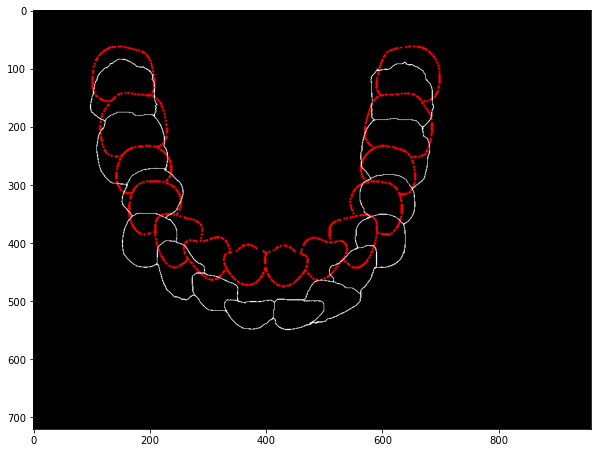

In [21]:
emopt.showEdgeMaskPredictionWithGroundTruth(canvasShape)

In [22]:
for _ in range(20):
    emopt.expectation_step(verbose=True)
    emopt.maximization_stage1_step()


Num of unique pred points: 568
Loss in expectation step: 124.94
Num of unique pred points: 571
Loss in expectation step: 78.62
Num of unique pred points: 666
Loss in expectation step: 40.49
Num of unique pred points: 744
Loss in expectation step: 20.82
Num of unique pred points: 790
Loss in expectation step: 18.77
Num of unique pred points: 754
Loss in expectation step: 17.93
Num of unique pred points: 806
Loss in expectation step: 17.15
Num of unique pred points: 810
Loss in expectation step: 16.65
Num of unique pred points: 797
Loss in expectation step: 16.82
Num of unique pred points: 814
Loss in expectation step: 16.66
Num of unique pred points: 810
Loss in expectation step: 16.82
Num of unique pred points: 789
Loss in expectation step: 16.57
Num of unique pred points: 799
Loss in expectation step: 16.62
Num of unique pred points: 801
Loss in expectation step: 16.23
Num of unique pred points: 774
Loss in expectation step: 16.35
Num of unique pred points: 794
Loss in expectation ste

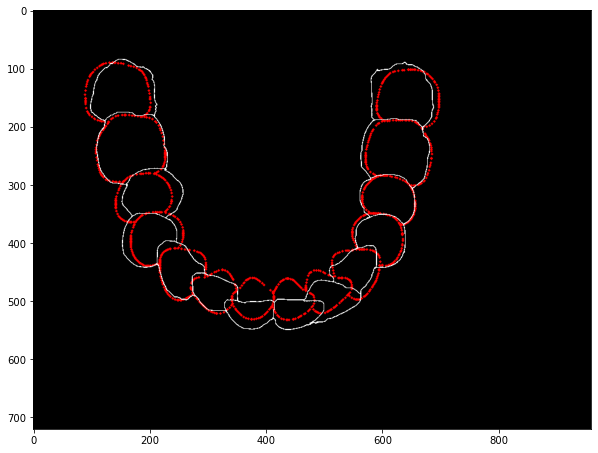

In [23]:
emopt.showEdgeMaskPredictionWithGroundTruth(canvasShape)

In [24]:
print("ex_rxyz: ", emopt.ex_rxyz)
print("ex_txyz: ", emopt.ex_txyz)
print("focal length: ", emopt.focLth)
print("d_pixel: ", emopt.dpix)
print("u0: {}, v0: {}".format(emopt.u0, emopt.v0))

ex_rxyz:  [1.00929423 3.2046156  3.14952413]
ex_txyz:  [ 0.25986511  3.81447973 74.41146396]
focal length:  50.65737471454545
d_pixel:  0.05919007892248468
u0: 402.59498422330853, v0: 309.3135241384278


In [25]:
# for it in range(30):
#     emopt.expectation_step(verbose=False)
#     emopt.maximization_stage1_step()
#     emopt.maximization_stage2_step(step=4)
#     print("iteration: {}, real mean L2 error(mm): {:.4f}".format(it, computeMeanL2Error(emopt.X_trans, X_Ref, shift_vec)))

In [26]:
for it in range(30):
    emopt.expectation_step(verbose=False)
    emopt.maximization_stage1_step()
    emopt.maximization_stage2_step(step=2)
    emopt.maximization_stage2_step(step=3)
    emopt.maximization_stage2_step(step=1)
    
    print("iteration: {}, real mean L2 error(mm): {:.4f}".format(it, computeMeanL2Error(emopt.X_trans, X_Ref, shift_vec)))

total error: 1384014.26, errorPixel:1381963.72, errorTeethPoseParam:2050.55
total error: 1364559.55, errorPixel:1361555.74, errorTeethPoseParam:3003.81
total error: 1146944.04, errorPixel:1137487.33, errorTeethPoseParam:9456.71
iteration: 0, real mean L2 error(mm): 1.6233
total error: 1130853.88, errorPixel:1119834.31, errorTeethPoseParam:11019.57
total error: 1110754.19, errorPixel:1096426.84, errorTeethPoseParam:14327.35
total error: 969771.18, errorPixel:944952.33, errorTeethPoseParam:24818.86
iteration: 1, real mean L2 error(mm): 1.5861
total error: 993386.41, errorPixel:967239.76, errorTeethPoseParam:26146.66
total error: 978313.78, errorPixel:950715.17, errorTeethPoseParam:27598.61
total error: 888832.57, errorPixel:854165.01, errorTeethPoseParam:34667.55
iteration: 2, real mean L2 error(mm): 1.5543
total error: 858908.35, errorPixel:824977.76, errorTeethPoseParam:33930.59
total error: 857685.22, errorPixel:822172.61, errorTeethPoseParam:35512.61
total error: 805568.65, errorPixe

KeyboardInterrupt: 

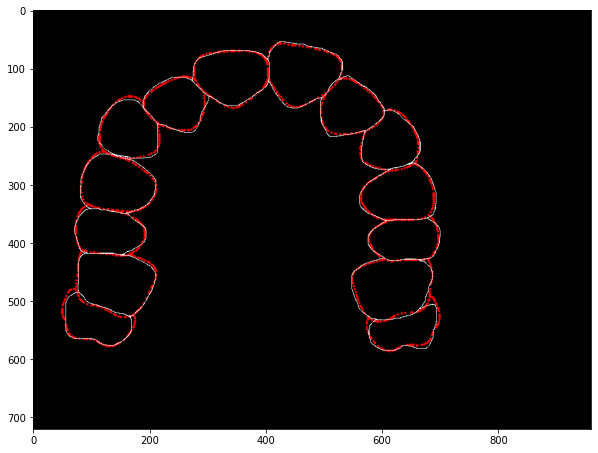

In [126]:
emopt.showEdgeMaskPredictionWithGroundTruth(canvasShape)

In [ ]:
for _ in range(3):
    emopt.expectation_step(verbose=True)
    # emopt.maximization_stage2_step(step=1)
    # emopt.maximization_stage2_step(step=2)
    # emopt.maximization_stage2_step(step=3)
    emopt.maximization_stage3_step()
    print("real mean L2 error(mm): {:.4f}".format(computeMeanL2Error(emopt.X_trans, X_Ref, shift_vec)))

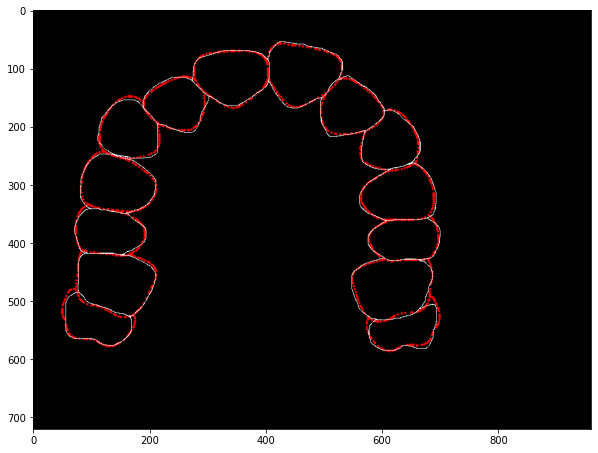

In [127]:
emopt.showEdgeMaskPredictionWithGroundTruth(canvasShape)

In [67]:
invRotAngleXYZVars = invRotAngleXYZVars.reshape(-1,3)
invTransVecXYZVars = invTransVecXYZVars.reshape(-1,3)
print("standard transVecXYZs:")
print((emopt.transVecXYZs - emopt.meanTransVecXYZs) / np.sqrt(invTransVecXYZVars[:14][Mask[:14]]))
print("standard rotAngleXYZs:")
print((emopt.rotAngleXYZs - emopt.meanRotAngleXYZs) / np.sqrt(invRotAngleXYZVars[:14][Mask[:14]]))
print("scales:")
print(emopt.scales)

standard transVecXYZs:
[[ 0.43071037  0.16052045  0.74590302]
 [ 0.64062146 -0.10848269  0.51906252]
 [ 0.0891495  -0.04664318 -0.12606642]
 [ 0.46240254  0.64673526  0.05534694]
 [-0.01530993  0.3765649  -0.244301  ]
 [-0.27180828  0.12409245 -0.38579458]
 [-0.57351021  0.23294863 -0.57808342]
 [-0.33021709  0.41005524 -0.07686359]
 [-0.22414448  0.18141178 -0.08187189]
 [-0.41957976  0.55185648 -0.21393549]
 [-0.93603153  0.22374307  0.05523653]
 [ 0.87641816  0.54092855 -0.6178569 ]
 [ 0.17248115  0.27152534 -0.1975712 ]
 [ 0.70262995 -0.06191861  0.22776939]]
standard rotAngleXYZs:
[[-0.10498089  0.53384048 -0.11938967]
 [ 0.11721837  0.0570352  -0.31203593]
 [ 0.07948298  0.62984099  0.53640138]
 [ 0.31242324  0.42549802 -0.14811123]
 [-0.0606948   0.16687102 -0.15121877]
 [-0.01251302 -0.06304392  0.07803163]
 [ 0.01699072  0.12144357  0.2209417 ]
 [ 0.93576909  0.32130594  0.45355698]
 [ 0.19917897  0.63363114  0.39756765]
 [ 0.00387595  0.46659544  0.34331213]
 [ 0.07769566 -0.

In [28]:
def showPredPointClouds(y,py):
    pcdY = o3d.geometry.PointCloud()
    pcdY.points = o3d.utility.Vector3dVector(y)
    pcdY.paint_uniform_color(np.array([1.,0.,0.]))
    pcdPY = o3d.geometry.PointCloud()
    pcdPY.points = o3d.utility.Vector3dVector(py)
    pcdPY.paint_uniform_color(np.array([0.,0.,1.]))
    o3d.visualization.draw_geometries([pcdY,pcdPY], window_name="Ground Truth PCL(red) and Prediction PCL(blue)", width=800, height=600, left=50,top=50, point_show_normal=False)

In [128]:
# 优化后对比
showPredPointClouds(y=X_Ref.reshape(-1,3),py=(emopt.X_trans+shift_vec).reshape(-1,3))

In [40]:
# 均值牙列模型
showPredPointClouds(y=X_Ref.reshape(-1,3),py=(emopt.X_Mu+shift_vec).reshape(-1,3))

### 验证忽略rowScale后的transVec是否正确

In [549]:
sample = invParamDF[invParamDF["tag"]==TagID]
toothIndices = UPPER_INDICES+LOWER_INDICES
invScalesColumns = ["{}s".format(id) for id in toothIndices]
invRotAngleXYZColumns = ["{}r{}".format(id, p) for id in toothIndices for p in ["x","y","z"]]
invTransVecXYZColumns = ["{}t{}".format(id, p) for id in toothIndices for p in ["x","y","z"]]

In [550]:
scales = sample[invScalesColumns].to_numpy().reshape((28,))
rotAngles = sample[invRotAngleXYZColumns].to_numpy().reshape((28,3))
transVecs = sample[invTransVecXYZColumns].to_numpy().reshape((28,3))
isp = 14
scales = scales[:isp][Mask[:isp]]
rotAngles = rotAngles[:isp][Mask[:isp]]
rotMats = np.array([utils.getRotMat(rxyz) for rxyz in rotAngles])
transVecs = transVecs[:isp][Mask[:isp]]
mu = Mu[:isp][Mask[:isp]]

In [551]:
pg = scales[:,None,None] * np.matmul((mu-mu.mean(axis=1,keepdims=True)), rotMats) + transVecs[:,None,:] + mu.mean(axis=1,keepdims=True)

In [552]:
ssaPath = "./data/ssa-repaired-txt/"
PGs = []
for tID in toothIndices:
    fp = os.path.join(ssaPath,str(tID),"{}U.txt".format(TagID))
    if os.path.exists(fp):
        x = np.loadtxt(fp)
        PGs.append(x)

In [553]:
ref_pgs = np.vstack(PGs)
initTransVecShifts = invRegistrationParamDF[invRegistrationParamDF["tag"]==TagID]["upper_ts"].values[0]
pg = pg + initTransVecShifts[:,None,:]

In [555]:
showPredPointClouds(y=ref_pgs,py=(pg).reshape(-1,3))